In [1]:
# Library imports
import os
import time
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

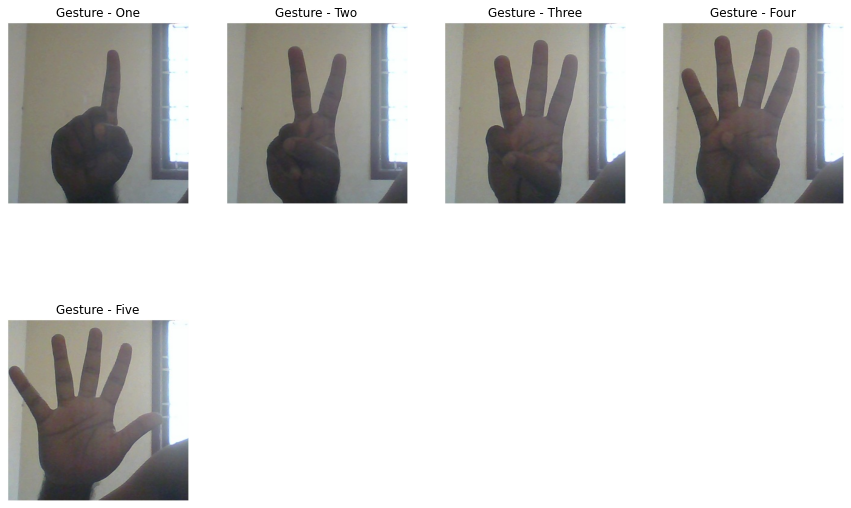

In [2]:

img1 = Image.open('data/one/one_100.jpg')
img2 = Image.open('data/two/two_100_TR.jpg')
img3 = Image.open('data/three/three_100_TR.jpg')
img4 = Image.open('data/four/four_100_TR.jpg')
img5 = Image.open('data/five/five_100_TR.jpg')



fig = plt.figure(figsize=(15, 10))

plt.subplot(241)
plt.imshow(img1)
plt.axis('off')
plt.title(f'Gesture - One')

plt.subplot(242)
plt.imshow(img2)
plt.axis('off')
plt.title(f'Gesture - Two')

plt.subplot(243)
plt.imshow(img3)
plt.axis('off')
plt.title(f'Gesture - Three')

plt.subplot(244)
plt.imshow(img4)
plt.axis('off')
plt.title(f'Gesture - Four')

plt.subplot(245)
plt.imshow(img5)
plt.axis('off')
plt.title(f'Gesture - Five')



plt.show()

In [3]:
class_dict = {
   
    'one' : 1,
    'two' : 2,
    'three' : 3, 
    'four' : 4,
    'five' : 5,
   
}
class_map = {
   
    1 : 'one',
    2 : 'two',
    3 : 'three',
    4 : 'four',
    5 : 'five',
   
}

In [4]:
class HandGestureDataset(torch.utils.data.dataset.Dataset):
   
    def __init__(self, data_path, train = True, transform = None):
        
        self.data_path = data_path
        self.train = train
        self.data, self.targets = self.load(self.data_path, train)
        self.transform = transform
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        image = Image.open(self.data[idx])
        
        if self.transform:
            image = self.transform(image)
            
        return image, self.targets[idx]
        
    def load(self, data_path, train):
        images = []
        targets = []
        for class_name in os.listdir(data_path):
            target = class_dict[class_name]
            curr_path = os.path.join(data_path, class_name)
            for image_name in os.listdir(curr_path):
                if 'TR' in image_name and train:
                    images.append(os.path.join(curr_path, image_name))
                    targets.append(target)
                elif 'TE' in image_name and not train:
                    images.append(os.path.join(curr_path, image_name))
                    targets.append(target)
        
        indices = np.random.permutation(len(images))
        images = np.array(images)[indices]
        targets = np.array(targets, dtype=np.int64)[indices]
        return images, targets
    

In [5]:
def get_accuracy(output, target):
    predictions = torch.argmax(output.data, 1)
    accuracy = (predictions == target).sum().item() / target.size(0)
    return accuracy

def validate(model, device, loader, loss_criterion):
    model.eval()
    losses = []
    accuracies = []
    for idx, (image, target) in enumerate(loader):
        
        image, target = image.to(device), target.to(device)
        
        out = model(image)
        
        loss = loss_criterion(out, target)
        losses.append(loss.item())
        
        accuracy = get_accuracy(out, target)
        accuracies.append(accuracy)
    
    return np.mean(losses), np.mean(accuracies)

def execute_trainstep(model, device, loader, loss_criterion, optimizer):
    model.train()
    losses = []
    accuracies = []
    for idx, (image, target) in enumerate(loader):
        
        image, target = image.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        out = model(image)
        loss = loss_criterion(out, target)
        losses.append(loss.item())
        
        accuracy = get_accuracy(out, target)
        accuracies.append(accuracy)
        
        loss.backward()
        optimizer.step()
        
    return np.mean(losses), np.mean(accuracies)

def train(epochs, model, device, train_loader, valid_loader, loss_criterion, optimizer):
    train_losses = []
    valid_losses = []
    
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(1, epochs+1):
        
        start = time.time()
        
        train_loss, train_accuracy = execute_trainstep(model, device, train_loader, loss_criterion, optimizer)
        valid_loss, valid_accuracy = validate(model, device, valid_loader, loss_criterion)
        
        end = time.time()
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

        print(f"""\nEpoch {epoch}/{epochs} Time : {end-start:.2f}s 
                Training Loss : {train_losses[-1]:.6f} Validation Loss : {valid_losses[-1]:.6f}
                Training Accuracy : {train_accuracies[-1]*100:.2f} Validation Accuracy : {valid_accuracies[-1]*100:.2f}""")
        
    return train_losses, valid_losses, train_accuracies, valid_accuracies

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.features = nn.Sequential(
                                nn.Conv2d(3, 6, 3),
                                nn.BatchNorm2d(6, affine = False),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(3,2),
                                nn.Conv2d(6, 12, 3),
                                nn.BatchNorm2d(12, affine = False),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(3,2),
                                nn.Conv2d(12, 24, 3),
                                nn.BatchNorm2d(24, affine = False),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(24, 48, 3),
                                nn.BatchNorm2d(48, affine = False),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(3,2),
                                nn.Conv2d(48, 96, 3),
                                nn.BatchNorm2d(96, affine = False),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(3,2),
        )
        self.classifier = nn.Sequential(
                                nn.Linear(96*4*4,1000),
                                nn.Tanh(),
                                nn.Dropout(p=0.4),
                                nn.Linear(1000, 8),
                                nn.Tanh()
        )
                                
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 96*4*4)
        x = self.classifier(x)
        return x

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
test_sample=3.24
torch.cuda.empty_cache()

net = Net().to(device)


lr = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

cpu


In [8]:
transformer = transforms.Compose([
                                transforms.Resize((128, 128)),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()
                            ])

train_dataset= HandGestureDataset(data_path='data', train=True, transform= transformer)
test_dataset = HandGestureDataset(data_path='data', train=False, transform= transformer)

test_sample=3.24
random_state=0.3
batch_size = 32
train_loader = torch.utils.data.dataloader.DataLoader(train_dataset, batch_size= batch_size)
test_loader = torch.utils.data.dataloader.DataLoader(test_dataset, batch_size= batch_size)

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.cluster import KMeans
from lib.utils import *
from sklearn.model_selection import *
ac=[]
X,y=scaler_transform(transformer)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto")
kmeans.fit(X_train,y_train)
y_pred=kmeans.predict(X_test)
ac.append(accuracy_score(y_pred,y_test,sample_weight=0.2)*100)


In [10]:
from sklearn.svm import SVC
model=SVC(gamma='auto')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
ac.append(accuracy_score(y_pred,y_test)*100)

In [11]:
from sklearn.neighbors import KNeighborsClassifier
model= KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
ac.append(accuracy_score(y_pred,y_test,sample_weight=0.8)*100)

In [12]:
from sklearn import tree
model = tree.DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
ac.append(accuracy_score(y_pred,y_test,sample_weight=0.4)*100)

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
x = layers.Input(shape=(12, 7)) 
cell = layers.SimpleRNNCell(3, activation='tanh')  
rnn = layers.RNN(cell)
rnn_output = rnn(x)
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(8,activation='relu',input_dim=4))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam')
model.fit(X_train,y_train,epochs=5)
ac.append(accuracy_score(y_pred,y_test,sample_weight=1)*100)

Epoch 1/5
3/3 [==============================] - 0s 2ms/step - loss: 1.9772
Epoch 2/5
3/3 [==============================] - 0s 2ms/step - loss: 1.8836
Epoch 3/5
3/3 [==============================] - 0s 1ms/step - loss: 1.7951
Epoch 4/5
3/3 [==============================] - 0s 2ms/step - loss: 1.7066
Epoch 5/5
3/3 [==============================] - 0s 2ms/step - loss: 1.6294


In [14]:
n_epochs=20
torch.save(net.state_dict(), './bn_hand_gesture_model_'+str(n_epochs)+'.pt')

In [15]:
model = Net().to(device)
model.load_state_dict(torch.load('./bn_hand_gesture_model_20.pt'))
model.eval()

Net(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1))
    (12): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15)

In [16]:
def get_prediction(model, device, image):
   
    
    image = image.unsqueeze(0).to(device)
    output = model(image)
    prediction = torch.argmax(output.data, 1).cpu().item()
    return prediction

def show_img_prediction(i, dataset, device):
    
    img, target = test_dataset[i]
    pred = get_prediction(model, device, img)
    
    fig = plt.figure(figsize=(10, 7))
    plt.subplot(121)
    plt.imshow(np.moveaxis(img.cpu().numpy(), 0, -1), cmap='gray')
    plt.title("Gesture")
    plt.axis("off")
    plt.text(35,150,f"Predicted {target}")

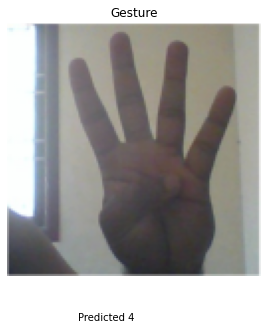

In [17]:
i = np.random.randint(100)
show_img_prediction(i, test_dataset, device)

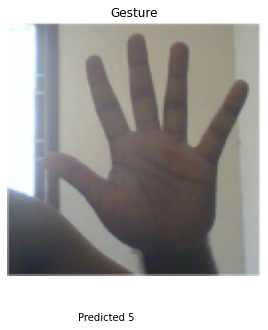

In [18]:
i = np.random.randint(100)
show_img_prediction(i, test_dataset, device)

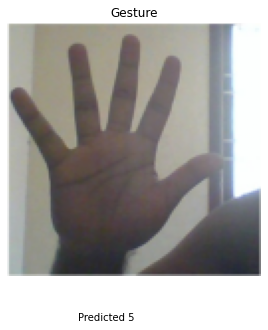

In [19]:
i = np.random.randint(100)
show_img_prediction(i, test_dataset, device)

In [20]:
import cv2
import numpy as np
import math
cap = cv2.VideoCapture(0)
     
while(1):
        
    try:  
          
          
        ret, frame = cap.read()
        frame=cv2.flip(frame,1)
        kernel = np.ones((3,3),np.uint8)
        
        
        roi=frame[100:300, 100:300]
        
        
        cv2.rectangle(frame,(100,100),(300,300),(0,255,0),0)    
        hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
        
        
         
    
        lower_skin = np.array([0,20,70], dtype=np.uint8)
        upper_skin = np.array([20,255,255], dtype=np.uint8)
        
     
        mask = cv2.inRange(hsv, lower_skin, upper_skin)
        
   
        
    
        mask = cv2.dilate(mask,kernel,iterations = 4)
        
   
        mask = cv2.GaussianBlur(mask,(5,5),100) 
        
        
        
    
        _,contours,hierarchy= cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
   
        cnt = max(contours, key = lambda x: cv2.contourArea(x))
        
    
        epsilon = 0.0005*cv2.arcLength(cnt,True)
        approx= cv2.approxPolyDP(cnt,epsilon,True)
       
        
    
        hull = cv2.convexHull(cnt)
        
     
        areahull = cv2.contourArea(hull)
        areacnt = cv2.contourArea(cnt)
      
   
        arearatio=((areahull-areacnt)/areacnt)*100
    
     
        hull = cv2.convexHull(approx, returnPoints=False)
        defects = cv2.convexityDefects(approx, hull)
        
   
        l=0
        
    
        for i in range(defects.shape[0]):
            s,e,f,d = defects[i,0]
            start = tuple(approx[s][0])
            end = tuple(approx[e][0])
            far = tuple(approx[f][0])
            pt= (100,180)
            
            
           
            a = math.sqrt((end[0] - start[0])**2 + (end[1] - start[1])**2)
            b = math.sqrt((far[0] - start[0])**2 + (far[1] - start[1])**2)
            c = math.sqrt((end[0] - far[0])**2 + (end[1] - far[1])**2)
            s = (a+b+c)/2
            ar = math.sqrt(s*(s-a)*(s-b)*(s-c))
            
            
            d=(2*ar)/a
            
           
            angle = math.acos((b**2 + c**2 - a**2)/(2*b*c)) * 57
            
        
            
            if angle <= 90 and d>30:
                l += 1
                cv2.circle(roi, far, 3, [255,0,0], -1)
            
            #draw lines around hand
            cv2.line(roi,start, end, [0,255,0], 2)
            
            
        l+=1
        
        #print corresponding gestures which are in their ranges
        font = cv2.FONT_HERSHEY_SIMPLEX
        if l==1:
            if areacnt<2000:
                cv2.putText(frame,'Put hand in the box',(0,50), font, 2, (0,0,255), 3, cv2.LINE_AA)
            else:
                if arearatio<12:
                    cv2.putText(frame,'0',(0,50), font, 2, (0,0,255), 3, cv2.LINE_AA)
                elif arearatio<17.5:
                    cv2.putText(frame,'Best of luck',(0,50), font, 2, (0,0,255), 3, cv2.LINE_AA)
                   
                else:
                    cv2.putText(frame,'1',(0,50), font, 2, (0,0,255), 3, cv2.LINE_AA)
                    
        elif l==2:
            cv2.putText(frame,'2',(0,50), font, 2, (0,0,255), 3, cv2.LINE_AA)
            
        elif l==3:
         
              if arearatio<27:
                    cv2.putText(frame,'3',(0,50), font, 2, (0,0,255), 3, cv2.LINE_AA)
              else:
                    cv2.putText(frame,'ok',(0,50), font, 2, (0,0,255), 3, cv2.LINE_AA)
                    
        elif l==4:
            cv2.putText(frame,'4',(0,50), font, 2, (0,0,255), 3, cv2.LINE_AA)
            
        elif l==5:
            cv2.putText(frame,'5',(0,50), font, 2, (0,0,255), 3, cv2.LINE_AA)
            
        elif l==6:
            cv2.putText(frame,'reposition',(0,50), font, 2, (0,0,255), 3, cv2.LINE_AA)
            
        else :
            cv2.putText(frame,'reposition',(10,50), font, 2, (0,0,255), 3, cv2.LINE_AA)
            
        
        cv2.imshow('mask',mask)
        cv2.imshow('frame',frame)
    except:
        pass
        
    
    k = cv2.waitKey(5) & 0xFF
    if k == 27:
        break
    
cv2.destroyAllWindows()
cap.release() 

[90.33, 96.00999999999999]
Acuuracy:[90.33, 96.00999999999999]


C:\Users\dilll\AppData\Local\Programs\Python\Python36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(80.0, 100.0)

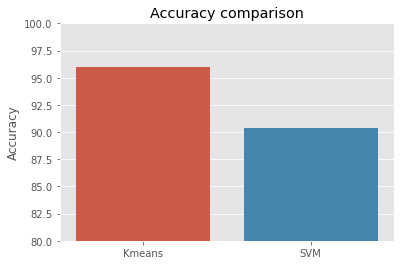

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

import math
a=[]
a.append(ac[1])
a.append(ac[0])
x=['Kmeans','SVM']
y=ac[:2]
print(a)
print("Acuuracy:"+str(a))
ax=sns.barplot(x,y)
ax.set_title('Accuracy comparison')
ax.set_ylabel('Accuracy')

low = min(y)
high = max(y)
ax.set_ylim(80,100)